# Openning data set and splitting to test, train, val

In [1]:
# import splitfolders

In [2]:
# input_folder = "dataset"
# output_folder = "processed_data"
# splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(.8,.1,.1))

In [3]:
# help(splitfolders.ratio)

# Importing required packages

In [4]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf

# Preprocessing

In [5]:
img_height, img_width = (224,224)
batch_size = 32

train_data_dir = r"processed_data\train"
valid_data_dir = r"processed_data\val"
test_data_dir = r"processed_data\test"

In [6]:
train_datagen =  ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.4) # set as training data


train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='validation') # set as validation data

test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    subset='validation',
                                                    shuffle=False ) # set as validation data

Found 6193 images belonging to 2 classes.
Found 515 images belonging to 2 classes.
Found 516 images belonging to 2 classes.


In [7]:
x, y = test_generator.next()
x.shape

(1, 224, 224, 3)

# Data analysis part

In [8]:
# Get a summary of the data distribution
train_data_counts = pd.Series(train_generator.classes).value_counts()
valid_data_counts = pd.Series(valid_generator.classes).value_counts()

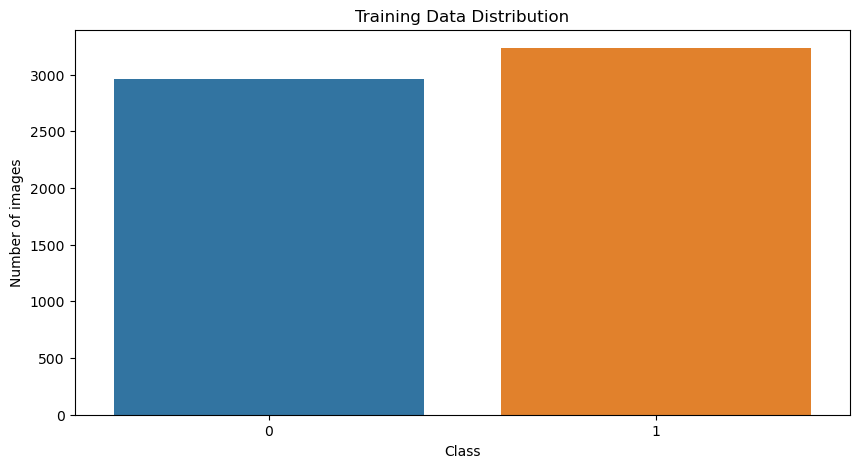

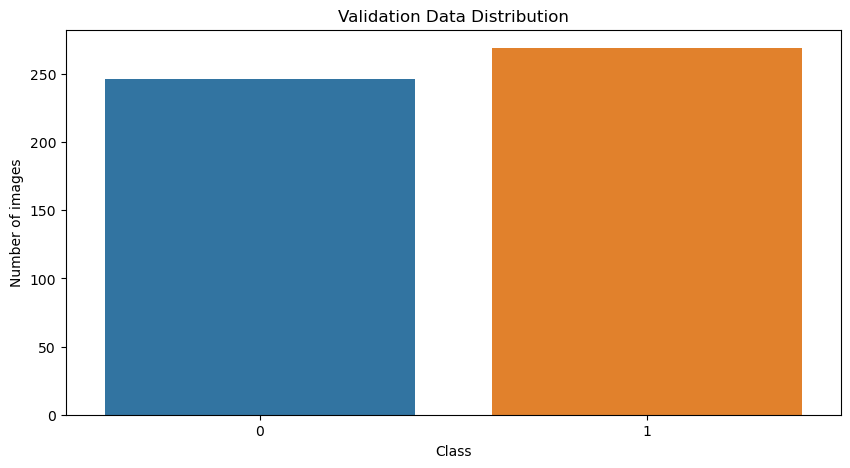

In [9]:
# Plot data distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=train_data_counts.index, y=train_data_counts.values)
plt.title('Training Data Distribution')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=valid_data_counts.index, y=valid_data_counts.values)
plt.title('Validation Data Distribution')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

# Display a few sample images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


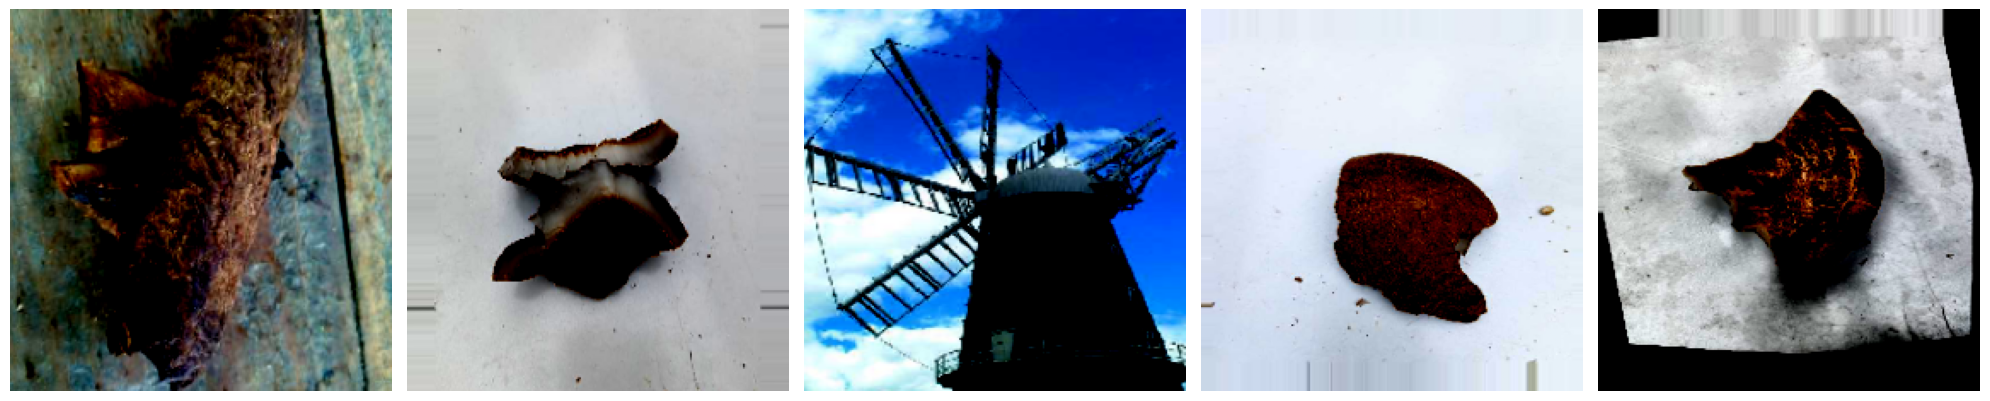

In [10]:
sample_images, _ = next(train_generator)
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
axes = axes.flatten()
for img, ax in zip(sample_images[:5], axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Modeling and Fitting

In [11]:
base_model = MobileNet(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(128, activation='relu')(x) 
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# model.summary()

# Freeze the layers of the base model

In [13]:
for layer in base_model.layers:
    layer.trainable = False

# Compile the model

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

# Define EarlyStopping to prevent overfitting

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model

In [16]:
history = model.fit(train_generator, validation_data=valid_generator, epochs = 20, callbacks=[early_stop])

Epoch 1/20
 66/194 [=========>....................] - ETA: 42s - loss: 0.1665 - accuracy: 0.9399

C:\Users\Jamith\anaconda3\envs\copra\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


194/194 [==============================] - 78s 364ms/step - loss: 0.0794 - accuracy: 0.9732 - val_loss: 0.0425 - val_accuracy: 0.9767
Epoch 2/20
194/194 [==============================] - 65s 336ms/step - loss: 0.0208 - accuracy: 0.9937 - val_loss: 0.0297 - val_accuracy: 0.9903
Epoch 3/20
194/194 [==============================] - 65s 337ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.0316 - val_accuracy: 0.9903
Epoch 4/20
194/194 [==============================] - 64s 331ms/step - loss: 0.0101 - accuracy: 0.9963 - val_loss: 0.0297 - val_accuracy: 0.9903
Epoch 5/20
194/194 [==============================] - 65s 333ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.0530 - val_accuracy: 0.9883
Epoch 6/20
194/194 [==============================] - 66s 338ms/step - loss: 0.0096 - accuracy: 0.9961 - val_loss: 0.0472 - val_accuracy: 0.9883
Epoch 7/20
194/194 [==============================] - 66s 339ms/step - loss: 0.0088 - accuracy: 0.9977 - val_loss: 0.0391 - val_accuracy: 0.9

# save the model

In [17]:
model.save('model\mobilenet\copra_identification_mobilenet.h5')

# Plot training & validation accuracy and loss values

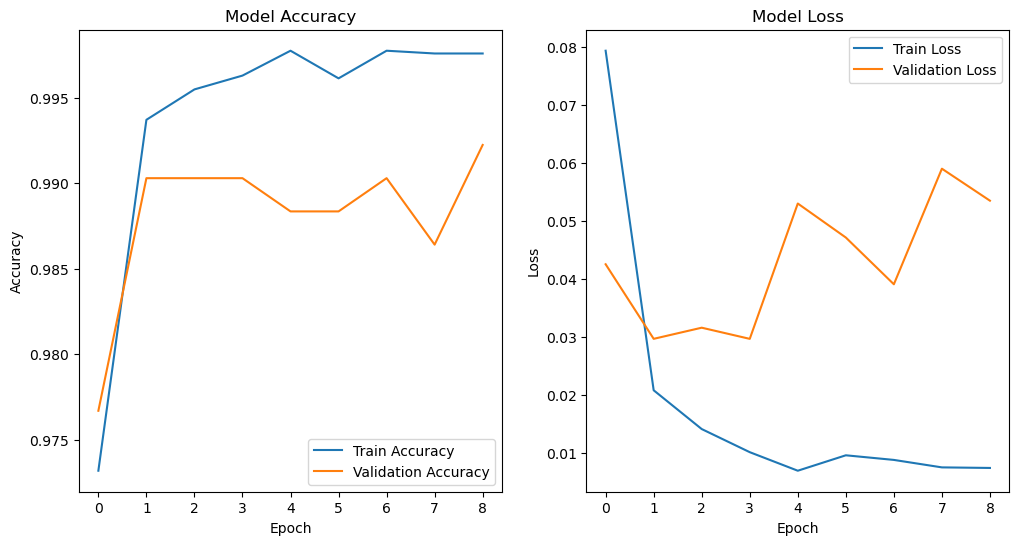

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

# Generate predictions

In [19]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report

In [20]:
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       copra       0.99      0.99      0.99       246
   non_copra       0.99      0.99      0.99       270

    accuracy                           0.99       516
   macro avg       0.99      0.99      0.99       516
weighted avg       0.99      0.99      0.99       516



# Confusion Matrix

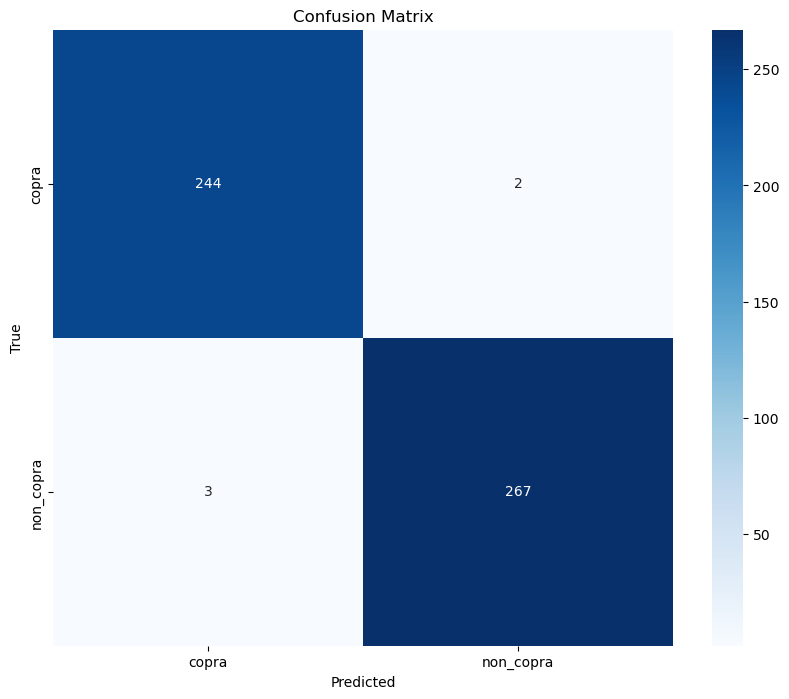

In [21]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot ROC Curves

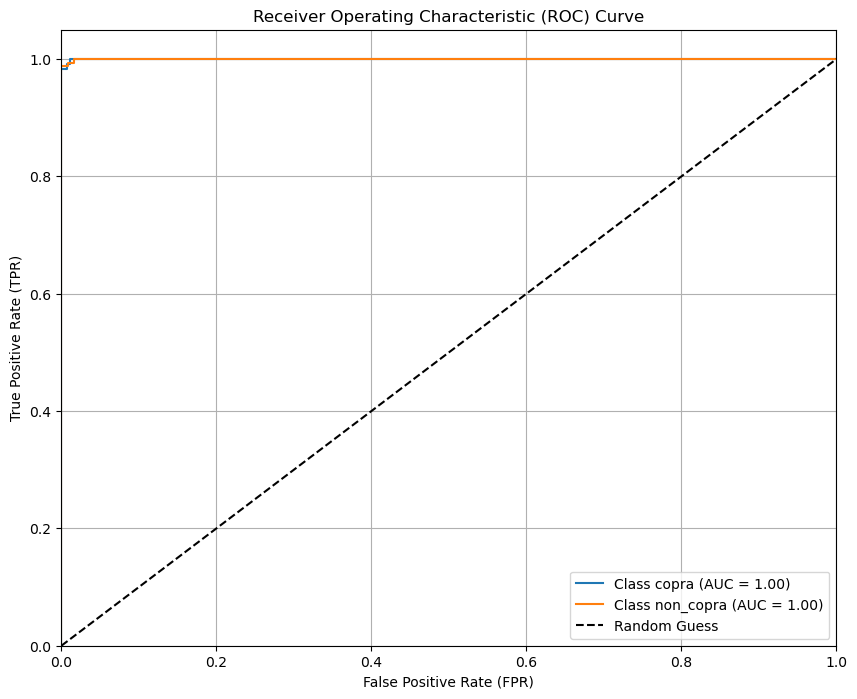

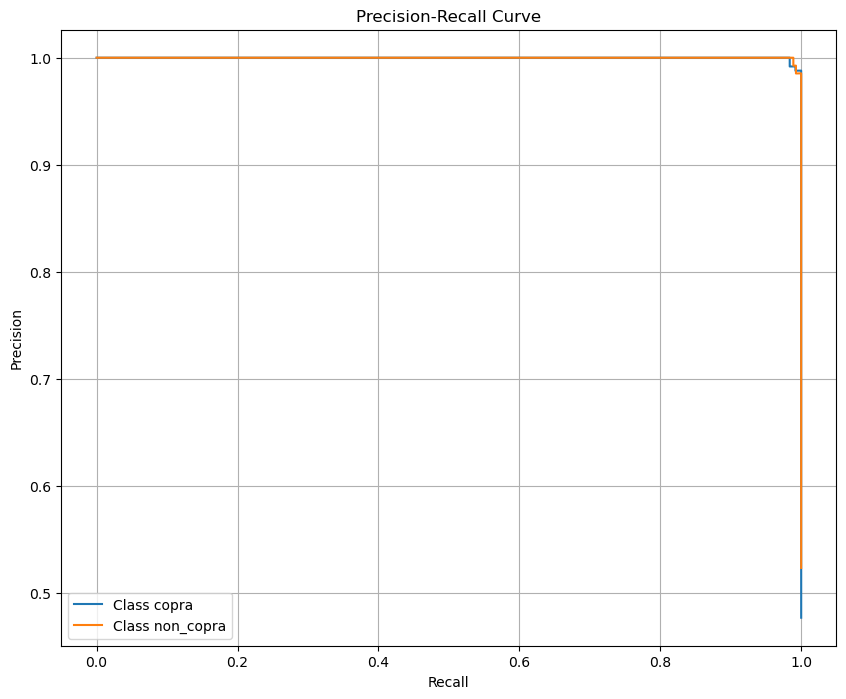

In [22]:
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true == i, predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    precision, recall, _ = precision_recall_curve(y_true == i, predictions[:, i])
    plt.plot(recall, precision, label=f'Class {class_labels[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [23]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest Accuracy:', test_acc*100)

516/516 - 5s - loss: 0.0191 - accuracy: 0.9864

Test Accuracy: 98.64341020584106


# Testing

516/516 [==============================] - 6s 11ms/step


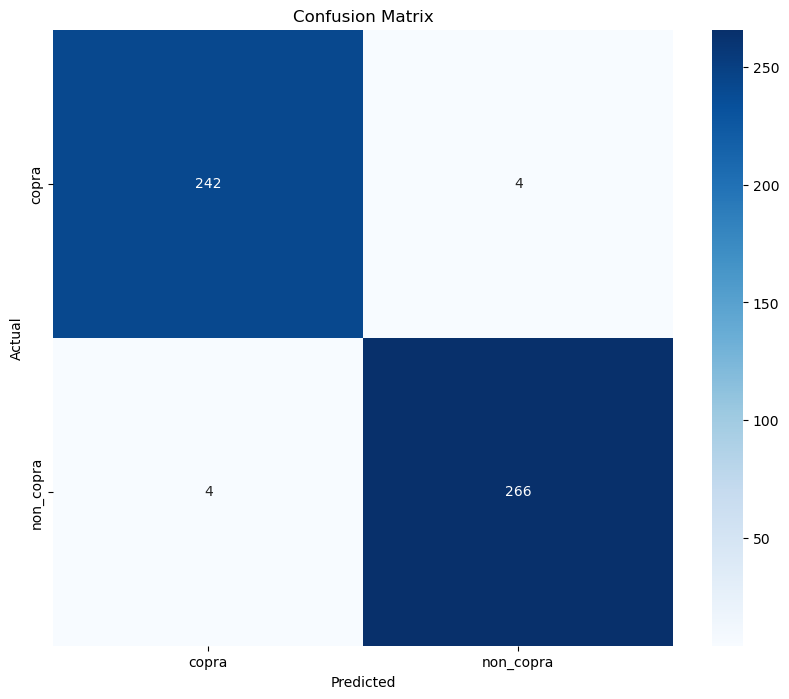

Confusion Matrix Accuracy: 98.45%
516/516 [==============================] - 7s 12ms/step - loss: 0.0154 - accuracy: 0.9903
Test Accuracy (model evaluation): 99.03%


In [24]:
import pandas as pd
import seaborn as sn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model('model/mobilenet/copra_identification_mobilenet.h5')

# Ensure test_generator is correctly configured
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_prob = np.argmax(predictions, axis=1)  # Predicted class indices
y_act = test_generator.classes  # True class indices

# Class labels
class_labels = list(test_generator.class_indices.keys())
predicted_class = [class_labels[i] for i in y_prob]
actual_class = [class_labels[i] for i in y_act]

# Create DataFrame for confusion matrix
out_df = pd.DataFrame({'predicted_class': predicted_class, 'actual_class': actual_class})
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'],
                               rownames=['Actual'], colnames=['Predicted'])

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sn.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# Accuracy from Confusion Matrix
confusion_accuracy = np.diagonal(confusion_matrix).sum() / confusion_matrix.sum().sum()
print(f"Confusion Matrix Accuracy: {confusion_accuracy * 100:.2f}%")

# Model's Evaluation Accuracy
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy (model evaluation): {test_accuracy * 100:.2f}%")


# Convert to TensorFlow Lite

In [25]:
# Load your Keras model
model = tf.keras.models.load_model('model/mobilenet/copra_identification_mobilenet.h5')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model/mobilenet/copra_identification_mobilenet.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Jamith\AppData\Local\Temp\tmp8tzdx5uh\assets


# Optimize the TFLite Model

In [26]:
# Post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the quantized TFLite model
with open('model/mobilenet/copra_identification_mobilenet_quant.tflite', 'wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Jamith\AppData\Local\Temp\tmp1y_db84s\assets


INFO:tensorflow:Assets written to: C:\Users\Jamith\AppData\Local\Temp\tmp1y_db84s\assets
